In [1]:
# Mount google drive for datasets
from google.colab import drive
drive = drive.mount('/content/drive')

Mounted at /content/drive


## Pre-processing - Cleaning of Reviews

In [2]:
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stopwords = stopwords.words('english')
import spacy
nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])


def preprocessing(comments):
  # Remove the spaces from start and end of reviews
  comments = comments.apply(lambda x: x.strip())

  # Remove the puntuations and numbers from sentences
  comments = comments.apply(lambda x: re.sub(r"[^a-zA-Z]", " ", x))

  # Converting to lower case
  comments = comments.apply(lambda x: x.lower())

  # Remove the stopwords from the sentences
  comments = comments.apply(lambda x: " ".join([word for word in x.split(" ") if word not in stopwords]))

  # Identifying pos tags and keeping only relevant words
  cleaned = comments.apply(lambda x: " ".join([str(token) for token in nlp(x) if token.pos_ in ['NOUN', 'ADJ', 'VERB', 'ADV']]))

  return cleaned

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


## Datasets

In [3]:
# Import tripadvisor dataset
import pandas as pd
sg_data = pd.read_csv('/content/drive/MyDrive/Hackathon/sg.csv', header = 0, sep = ',')

# Applying pre-processing in comment column
sg_data['clean_comment'] = preprocessing(sg_data['comment'])

sg_data.head()

,Unnamed: 0,Airlines,main_link,Plane_type,pt_link,date_seat,comment,clean_comment
0,0,Aegean Airlines,/airlines/Aegean_Airlines/information.php,Airbus A319 (319),/airlines/Aegean_Airlines/Aegean_Airlines_Airb...,on \n ...,\n ...,seat extra legroom
1,1,Aegean Airlines,/airlines/Aegean_Airlines/information.php,Airbus A320 (320),/airlines/Aegean_Airlines/Aegean_Airlines_Airb...,on \n ...,\n ...,aircraft chose position place awkward foot spa...
2,2,Aegean Airlines,/airlines/Aegean_Airlines/information.php,Airbus A320 (320),/airlines/Aegean_Airlines/Aegean_Airlines_Airb...,on \n ...,\n ...,tiny leg room quite tall flight attendants fri...
3,3,Aegean Airlines,/airlines/Aegean_Airlines/information.php,Airbus A320 (320),/airlines/Aegean_Airlines/Aegean_Airlines_Airb...,on \n ...,\n ...,exit nice hour flight back quite empty seats c...
4,4,Aegean Airlines,/airlines/Aegean_Airlines/information.php,Airbus A320 (320),/airlines/Aegean_Airlines/Aegean_Airlines_Airb...,on \n ...,\n ...,wonderful seat additional cost subject availab...


In [4]:
sg_data.to_csv('/content/drive/MyDrive/Hackathon/Tripadvisor_sg_cleaned_data.csv', header = True, index = False)

In [5]:
# Import Skytrax dataset
aqs_data = pd.read_csv('/content/drive/MyDrive/Hackathon/AQS_data_seat.csv', header=0, sep=',')

# Apply pre-processing in content column
aqs_data['clean_content'] = preprocessing(aqs_data['content'])
aqs_data['clean_content'] = aqs_data['clean_content'].apply(lambda x: x.lstrip('trip verified'))

aqs_data.head()

,Unnamed: 0,airline,title,date,content,rate,SeatType,AircraftType,SeatLayout,clean_content
0,0,aegean-airlines,"""middle seat was kept empty""",23rd October 2021,✅ Trip Verified | Seating seemed to be the sa...,5.0,Business Class,A320,2x2,seating seemed economy exception middle seat k...
1,1,aegean-airlines,"""have to pay for extra leg room""",25th February 2020,"✅ Trip Verified | Very good overall, but I'm ...",4.0,Economy Class,A320,3x3,good overall taller seats narrow find disgusti...
2,2,aegean-airlines,"""Never had less legroom""",21st February 2020,✅ Trip Verified | Never had less legroom on a...,1.0,Economy Class,A320neo,3x3,never less legroom flight flight seat pitch na...
3,3,aegean-airlines,"""little leg space at all""",5th October 2019,✅ Trip Verified | Horrible experience. Seats ...,3.0,Economy Class,A320,3x3,horrible experience seats pressed together eve...
4,4,aegean-airlines,"""never had less legroom""",26th August 2019,✅ Trip Verified | Overall Aegean is a decent ...,1.0,Economy Class,A321,3x3,overall aegean decent airline deal little legr...


In [6]:
aqs_data.to_csv('/content/drive/MyDrive/Hackathon/Skytrax_aqs_cleaned_data.csv', header = True, index = False)

In [5]:
#aqs_data[['content', 'clean_content']]

In [6]:
# List of reveiws for topic modelling

# Reviews from Tripadvisor dataset
sg_comments = sg_data.loc[:, 'clean_comment'].tolist()
print("Number of reviews from Tripadvisor dataset:", len(sg_comments))

# Reviews from Skytrax dataset
aqs_comments = aqs_data.loc[:, 'clean_content'].tolist()
print("Number of reviews from Skytrax dataset:", len(aqs_comments))

# Combining review from both datasets
data = sg_comments + aqs_comments
print("Total number of reviews:", len(data))

Number of reviews from Tripadvisor dataset: 17340
Number of reviews from Skytrax dataset: 2846
Total number of reviews: 20186


In [7]:
#data[:5]

# Topic Modelling Method 1 - HDBSCAN Clustering and LDA

### Tokenization and Stemming

In [8]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stopwords = stopwords.words('english')
# for including addition stopwords 
# stopwords.extend()
print(len(stopwords))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
179


In [9]:
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import word_tokenize
import re
nltk.download('punkt')
def TokenizationStemming(text):
  #Remove punctuation characters and numbers
  text = re.sub(r"[^a-zA-Z]", " ", text)

  #Tokenize Text
  tokens = word_tokenize(text)

  #Create a instance of stem class
  stemmer = SnowballStemmer("english")

  clean_tokens = []
  for word in tokens:
    clean_tok = stemmer.stem(word).lower().strip()
    if clean_tok not in stopwords:
      clean_tokens.append(clean_tok)

  return clean_tokens

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [10]:
# Test
#TokenizationStemming(data[1])

### TF-IDF Matrix

In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_model = TfidfVectorizer(
    max_df = 0.99,
    max_features = 1000,
    min_df = 0.01,
    use_idf = True,
    tokenizer = TokenizationStemming,
    ngram_range = (1,1) 
)

tfidf_matrix = tfidf_model.fit_transform(data)

print(tfidf_matrix.shape)

(20186, 482)


### UMAP & HDBSCAN Clustering

In [14]:
!pip install umap-learn

import umap.umap_ as umap

In [15]:
# Dimensionality Reduction - First use Truncated SVD to reduce the dimension to reasonable amount and then use UMAP

from sklearn.decomposition import TruncatedSVD
import umap

svd_model = TruncatedSVD(n_components = 50)
svd_tfidf = svd_model.fit_transform(tfidf_matrix)

umap_model = umap.UMAP()
umap_tfidf = umap_model.fit_transform(svd_tfidf)

/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


In [16]:
# Applying HDBSCAN on the UMAP output

!pip install hdbscan

import hdbscan

cluster = hdbscan.HDBSCAN(min_cluster_size=15, metric='euclidean', cluster_selection_method='eom').fit(umap_tfidf)
labels_hdb = cluster.labels_

     |████████████████████████████████| 5.2 MB 4.5 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for hdbscan: filename=hdbscan-0.8.28-cp37-cp37m-linux_x86_64.whl size=2330823 sha256=7b6626cabe1e6366766af0bc716f150d11a212bd41e97a15f7f65cd19bc4e2ee
  Stored in directory: /root/.cache/pip/wheels/6e/7a/5e/259ccc841c085fc41b99ef4a71e896b62f5161f2bc8a14c97a
Successfully built hdbscan


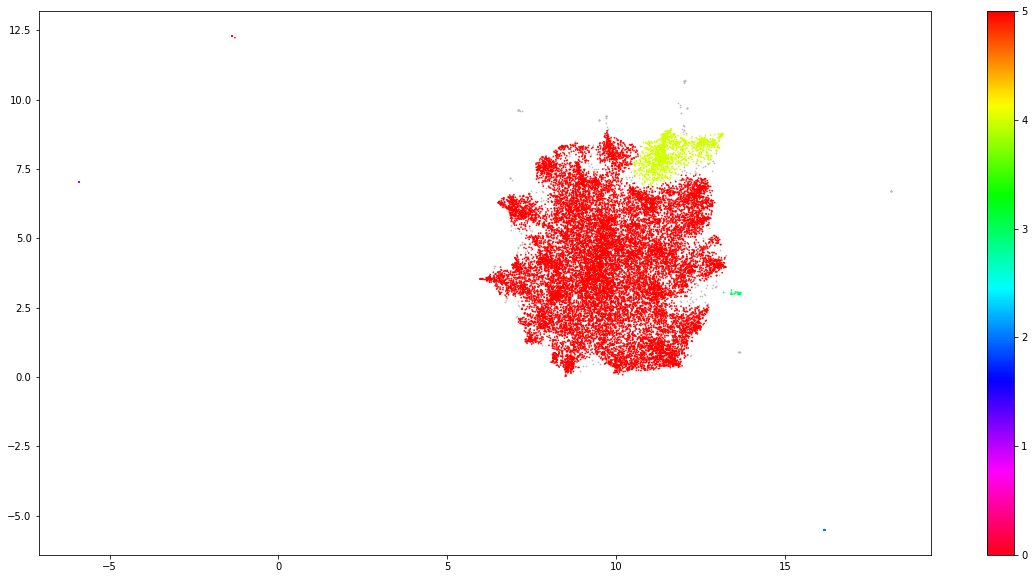

In [17]:
# Visualize the clusters 

# Prepare Data
result = pd.DataFrame(umap_tfidf, columns = ['x','y'])
result['labels'] = labels_hdb
#print(result.head())

# Plot
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(20,10))
outliers = result.loc[result.labels == -1,:]
clustered = result.loc[result.labels != -1,:]
plt.scatter(outliers.x, outliers.y, color = '#BDBDBD', s=0.5)
plt.scatter(clustered.x, clustered.y, c = clustered.labels, s=0.5, cmap='hsv_r')
plt.colorbar()

### Applying LDA

In [18]:
from sklearn.decomposition import LatentDirichletAllocation
LDA = LatentDirichletAllocation(n_components = 30)

In [19]:
# Document-topic matrix

lda_output = LDA.fit_transform(tfidf_matrix)
print(lda_output.shape)

(20186, 30)


In [20]:
# Topic-word matrix

topic_word = LDA.components_
print(topic_word.shape)

(30, 482)


In [21]:
# Probability of all the topics belonging to each document

import numpy as np
topic_names = ["topic" + str(i) for i in range(LDA.n_components)]
doc_names = ["doc" + str(i) for i in range(len(data))]

df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns = topic_names, index = doc_names)

final_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['topic'] = final_topic

df_document_topic.head()

,topic0,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,topic9,topic10,topic11,topic12,topic13,topic14,topic15,topic16,topic17,topic18,topic19,topic20,topic21,topic22,topic23,topic24,topic25,topic26,topic27,topic28,topic29,topic
doc0,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.63,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,19
doc1,0.01,0.01,0.01,0.01,0.74,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,4
doc2,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.51,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.25,0.01,0.01,0.01,0.01,13
doc3,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.77,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,13
doc4,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.72,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,10


In [22]:
# Print top 10 keywords for each topic

def print_topic_words(tfidf_model, lda_model, n_words):
  words = np.array(tfidf_model.get_feature_names())
  topic_words = []
  for topic_words_weights in lda_model.components_:
    top_words = topic_words_weights.argsort()[::-1][:n_words]
    topic_words.append(words.take(top_words))
  return topic_words

topic_keywords = print_topic_words(tfidf_model = tfidf_model, lda_model = LDA, n_words = 10)

df_topic_words = pd.DataFrame(topic_keywords)
df_topic_words.head()


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,0,1,2,3,4,5,6,7,8,9
0,terribl,hit,seat,hand,kept,bad,pain,aisl,leg,passeng
1,seat,armrest,reduc,narrow,row,width,slight,due,tray,tabl
2,busi,class,seat,economi,flight,coach,fli,first,product,plane
3,seat,bed,pillow,posit,adjust,comfort,sleep,flat,blanket,headrest
4,box,seat,space,leg,limit,front,restrict,foot,entertain,room


# Topic Modelling Method 2: BERTopic

In [23]:
!pip install bertopic

from bertopic import BERTopic

     |████████████████████████████████| 57 kB 2.7 MB/s 
     |████████████████████████████████| 79 kB 6.8 MB/s 
     |████████████████████████████████| 3.5 MB 46.2 MB/s 
     |████████████████████████████████| 1.2 MB 47.0 MB/s 
     |████████████████████████████████| 67 kB 5.5 MB/s 
     |████████████████████████████████| 895 kB 49.4 MB/s 
     |████████████████████████████████| 6.8 MB 34.8 MB/s 
     |████████████████████████████████| 636 kB 48.9 MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.0-py3-none-any.whl size=120747 sha256=86b85f55924c733a5b82c194bac0624b215f692c9f86183016d2b8ba3c033124
  Stored in directory: /root/.cache/pip/wheels/83/c0/df/b6873ab7aac3f2465aa9144b6b4c41c4391cfecc027c8b07e7
Successfully built sentence-transformers
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [24]:
model = BERTopic(verbose = True,
                 nr_topics = 30,
                 n_gram_range=(1,2))

# fit the model on full list of reviews
topics, probabilites = model.fit_transform(data)

Downloading:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/10.2k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/612 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/116 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/39.3k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/349 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/350 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/13.2k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/631 [00:00<?, ?it/s]

2022-02-18 08:05:31,512 - BERTopic - Transformed documents to Embeddings
2022-02-18 08:06:08,090 - BERTopic - Reduced dimensionality with UMAP
2022-02-18 08:06:11,728 - BERTopic - Clustered UMAP embeddings with HDBSCAN
2022-02-18 08:06:19,544 - BERTopic - Reduced number of topics from 138 to 31


In [25]:
# Distribution of sentences on various topics
# model.get_topic_freq().head(10)

In [26]:
print('Total number of topics created:',len(model.get_topic_freq()))

Total number of topics created: 31


In [27]:
# Top 10 words for each topics

import numpy as np
topics_descr = pd.DataFrame()
for i in np.unique(topics):
  top_words = ", ".join([word[0] for word in model.get_topic(i)])
  topics_descr = topics_descr.append([[i, top_words]])
topics_descr.reset_index(inplace = True, drop = True)
topics_descr.columns = ['topic_idx', 'top_words']
topics_descr['count_of_review'] = model.get_topic_freq()['Count']
topics_descr.head(30)

,topic_idx,top_words,count_of_review
0,-1,"seat, seats, flight, economy, good, front, cla...",15016
1,0,"noise, noisy, loud, engine, seat, plane, galle...",513
2,1,"storage, overhead, overhead storage, luggage, ...",393
3,2,"recline, row, seat, seats, reclined, exit, rec...",376
4,3,"armrest, tray, arm, table, tray table, armrest...",320
5,4,"business, business class, class, class seat, s...",293
6,5,"toilets, toilet, people, close, seat, seats, w...",272
7,6,"food, service, good, great, flight, drinks, ex...",238
8,7,"cold, air, vents, freezing, hot, door, exit, w...",235
9,8,"economy, premium, premium economy, extra, clas...",186


In [ ]:
# Export the file with top words for each topic index
topics_descr.to_csv('/content/drive/MyDrive/Hackathon/TopWordsForTopics.csv', header = True)

# Final Output

In [28]:
# Merging the Tripadvisor and Skytrax dataset 

output = pd.DataFrame()
output['Airline'] = sg_data['Airlines'].tolist() + aqs_data['airline'].tolist()
output['Aircraft'] = sg_data['Plane_type'].tolist() + aqs_data['AircraftType'].tolist()
output['Reviews'] = sg_data['comment'].tolist() + aqs_data['content'].tolist()
output['Topic_idx'] = topics
output.head()

,Airline,Aircraft,Reviews,Topic_idx
0,Aegean Airlines,Airbus A319 (319),\n ...,-1
1,Aegean Airlines,Airbus A320 (320),\n ...,-1
2,Aegean Airlines,Airbus A320 (320),\n ...,6
3,Aegean Airlines,Airbus A320 (320),\n ...,-1
4,Aegean Airlines,Airbus A320 (320),\n ...,2


In [29]:
# Cleaning some columns before exporting the output

output['Airline'] = output['Airline'].apply(lambda x: x.strip()).apply(lambda x: re.sub(r"[^a-zA-Z]", " ", x)).apply(lambda x: x.lower())
output['Aircraft'] = output['Aircraft'].apply(lambda x: re.sub("[\(\[].*?[\)\]]", "", x)).apply(lambda x: x.strip())
output['Reviews'] = output['Reviews'].apply(lambda x: x.strip()).apply(lambda x: re.sub(r"[^a-zA-Z]", " ", x)).apply(lambda x: x.lower())

output.head()

,Airline,Aircraft,Reviews,Topic_idx
0,aegean airlines,Airbus A319,from istabul to athens seat c doesnt have a...,-1
1,aegean airlines,Airbus A320,i traveled athens zurich with aegean airlines ...,-1
2,aegean airlines,Airbus A320,very tiny leg room as i am quite tall flight ...,6
3,aegean airlines,Airbus A320,exit row f was nice for the hour zrh ath...,-1
4,aegean airlines,Airbus A320,it is a wonderful seat at no additional cost ...,2


In [ ]:
# Exporing the output to csv
output.to_csv('/content/drive/MyDrive/Hackathon/Final_Output_V2.csv', header = True, index= False)

In [ ]:
# Top Airline by count of reviews

output['Airline'].value_counts()

delta                1829
british airways      1826
american airlines    1631
united               1426
air canada            890
                     ... 
malawian airlines       1
meridiana               1
mihin lanka             1
olympic air             1
xl airways france       1
Name: Airline, Length: 248, dtype: int64

In [30]:
# Top Aircrafts by count of reviews

output['Aircraft'].value_counts()

Boeing 777-300ER                1037
Boeing 787-8                     945
Airbus A380-800                  939
Boeing 737-800                   724
Boeing 787-9                     697
                                ... 
BOEING 747-400 / AIRBUS A330       1
Boeing 744-400                     1
B777/A340                          1
A320-214                           1
A320-200 neo                       1
Name: Aircraft, Length: 513, dtype: int64